In [2]:
#Import the required libraries

import numpy as np 
import pandas as pd 
import re  

import nltk 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
tweet = pd.read_csv("Datasets/train.csv")


In [4]:
tweet .head()


,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral
1,Playing Ghost Online is really interesting. Th...,positive
2,is cleaning the house for her family who is co...,neutral
3,gotta restart my computer .. I thought Win7 wa...,neutral
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral


In [5]:
tweet.tail()

,text,sentiment
27443,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative
27444,rec game....trying not to cry...the pain is to...,negative
27445,Sure. I`ll try n keep that up! =P You enjoy s...,positive
27446,Naw.. it was pretty tame. Only 1 guy in costu...,neutral
27447,morning twit-friends! welcome to my new followers,positive


In [6]:
tweet.shape

(27448, 2)

In [7]:
tweet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27448 entries, 0 to 27447
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27447 non-null  object
 1   sentiment  27448 non-null  object
dtypes: object(2)
memory usage: 429.0+ KB


# <u>DATA PREPROCESSING</u>

=> Dropping values which are null

In [8]:
tweet.dropna(subset=['text'])

,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral
1,Playing Ghost Online is really interesting. Th...,positive
2,is cleaning the house for her family who is co...,neutral
3,gotta restart my computer .. I thought Win7 wa...,neutral
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral
...,...,...
27443,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative
27444,rec game....trying not to cry...the pain is to...,negative
27445,Sure. I`ll try n keep that up! =P You enjoy s...,positive
27446,Naw.. it was pretty tame. Only 1 guy in costu...,neutral


=> removing @users since they do not contribute to the analysis.

In [9]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    

for x in range(tweet.shape[0]):
    tweet['text'][x] = np.vectorize(remove_pattern)(str(tweet['text'][x]), "@[\w]*") 

In [10]:
tweet.head()
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27448 entries, 0 to 27447
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27448 non-null  object
 1   sentiment  27448 non-null  object
dtypes: object(2)
memory usage: 429.0+ KB


In [11]:
X = tweet.iloc[:, 0].values  
y = tweet.iloc[:, 1].values

In [12]:
processed_tweets = []

for text in range(0, len(X)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(X[text]))
 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    #Removing numbers from the tweet
    processed_tweet = re.sub(r'\d', ' ', processed_tweet)
 
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
 
    processed_tweets.append(processed_tweet)

In [13]:
processed_tweets

[' oh marly m so sorry hope you find her soon    ',
 'playing ghost online is really interesting the new updates are kirin pet and metamorph for third job can wait to have dragon pet',
 'is cleaning the house for her family who is comming later today ',
 'gotta restart my computer thought win  was supposed to put an end to the constant rebootiness',
 'see wat mean bout foll w friidays it called lose f llowers friday smh',
 'the free fillin app on my ipod is fun im addicted',
 ' m sorry ',
 'on the way to malaysia no internet access to twit',
 'juss came backk from berkeleyy omg its madd fun out there havent been out there in minute whassqoodd ',
 'went to sleep and there is power cut in noida power back up not working too',
 'i going home now have you seen my new twitter design quite heavenly isn ',
 'i hope unni will make the audition fighting dahye unni ',
 ' if it is any consolation got my bmi tested hahaha it says am obesed well so much for being unhappy for about    minutes ',
 ' 

In [14]:
processed_tweets = np.array(processed_tweets) 

In [15]:
processed_tweets = pd.DataFrame(data=processed_tweets, columns=["tidy_text"]) #Creating a new dataframe which consists of tidy tweets.

In [16]:
processed_tweets.head()

,tidy_text
0,oh marly m so sorry hope you find her soon
1,playing ghost online is really interesting the...
2,is cleaning the house for her family who is co...
3,gotta restart my computer thought win was sup...
4,see wat mean bout foll w friidays it called lo...


=> Removing words which are lesser than the length of 3 since terms like 'oh', etc do not contribute to the analysis.

In [17]:
processed_tweets['tidy_text'] = processed_tweets['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=3]))

=> Tokenizing the clean tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [18]:
tokenized_tweet = processed_tweets['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0           [marly, sorry, hope, you, find, her, soon]
1    [playing, ghost, online, really, interesting, ...
2    [cleaning, the, house, for, her, family, who, ...
3    [gotta, restart, computer, thought, win, was, ...
4    [see, wat, mean, bout, foll, friidays, called,...
Name: tidy_text, dtype: object

=> Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.

In [19]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [(wnl.lemmatize(i) if wnl.lemmatize(i).endswith('e') else stemmer.stem(i)) for i in x]) # stemming
tokenized_tweet.head()

0           [marli, sorri, hope, you, find, her, soon]
1    [play, ghost, online, realli, interest, the, n...
2    [clean, the, house, for, her, famili, who, com...
3    [gotta, restart, comput, thought, win, wa, sup...
4    [see, wat, mean, bout, foll, friiday, call, lo...
Name: tidy_text, dtype: object

=> Joining the tokens back together.

In [20]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    processed_tweets['tidy_text'] = tokenized_tweet

In [21]:
tweet.head()

,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral
1,Playing Ghost Online is really interesting. Th...,positive
2,is cleaning the house for her family who is co...,neutral
3,gotta restart my computer .. I thought Win7 wa...,neutral
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral


In [22]:
processed_tweets['tidy_text']

0                       marli sorri hope you find her soon
1        play ghost online realli interest the new upda...
2        clean the house for her famili who com later t...
3        gotta restart comput thought win wa suppos put...
4        see wat mean bout foll friiday call lose llowe...
                               ...                        
27443    like drew said give chance will miss thoma but...
27444    rec game tri not cri the pain much need him ca...
27445               sure tri keep that you enjoy studi cya
27446    naw wa pretti tame onli guy costume voyag styl...
27447                  morn twit friend welcome new follow
Name: tidy_text, Length: 27448, dtype: object

=> Adding the tidy and cleaned texts to our original dataframe.

In [23]:
tweet['tidy_text']= processed_tweets['tidy_text']

In [24]:
tweet.head()

,text,sentiment,tidy_text
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral,marli sorri hope you find her soon
1,Playing Ghost Online is really interesting. Th...,positive,play ghost online realli interest the new upda...
2,is cleaning the house for her family who is co...,neutral,clean the house for her famili who com later t...
3,gotta restart my computer .. I thought Win7 wa...,neutral,gotta restart comput thought win wa suppos put...
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral,see wat mean bout foll friiday call lose llowe...


In [25]:
tweet.columns

Index(['text', 'sentiment', 'tidy_text'], dtype='object')

=> Mapping the sentiments to numerical values manually.

In [26]:
di = {'positive': "2", 'neutral': "1", 'negative' : "0"}

tweet['sentiment'] = tweet['sentiment'].map(di)

In [27]:
tweet.head()

,text,sentiment,tidy_text
0,"oh Marly, I`m so sorry!! I hope you find her...",1,marli sorri hope you find her soon
1,Playing Ghost Online is really interesting. Th...,2,play ghost online realli interest the new upda...
2,is cleaning the house for her family who is co...,1,clean the house for her famili who com later t...
3,gotta restart my computer .. I thought Win7 wa...,1,gotta restart comput thought win wa suppos put...
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,1,see wat mean bout foll friiday call lose llowe...


=> Displaying a word cloud to show which words are commonly used.

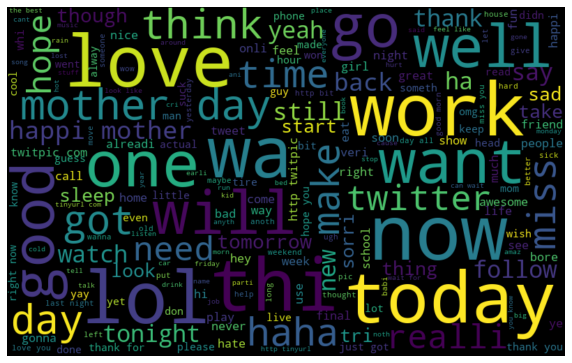

In [50]:
all_words = ' '.join([text for text in tweet['tidy_text']])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

=> The TfidfVectorizer  class from the sklearn.feature_extraction.text module can be used to create feature vectors containing TF-IDF values.

In [47]:
from sklearn.svm import SVC
pipe = Pipeline([('vect', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer()),
                 ('model', SVC(probability=True, kernel="linear", class_weight="balanced"))])

   # <u>Prediction</u>

In [48]:
X_train, X_test, y_train, y_test = train_test_split(tweet['tidy_text'], 
                                                 tweet.sentiment, test_size=0.2, random_state=2020)

=> Trying out SVC without tuning

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(pipe, X_train, y_train, cv=cv)
print ("\n Cross Validation Scores on the training set: ", scores)


modelNB = pipe.fit(X_train, y_train)
prediction = modelNB.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nCONFUSION MATRIX: \n\n", confusion_matrix(y_test, prediction))
print("\nCLASSIFICATION REPORT: \n\n", classification_report(y_test, prediction))


 Cross Validation Scores on the training set:  [0.68700668 0.70097146 0.6883728  0.69672131 0.69383728]
accuracy: 70.69%
accuracy: 70.69%

CONFUSION MATRIX: 

 [[1062  392   97]
 [ 377 1519  289]
 [ 112  342 1300]]

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1551
           1       0.67      0.70      0.68      2185
           2       0.77      0.74      0.76      1754

    accuracy                           0.71      5490
   macro avg       0.71      0.71      0.71      5490
weighted avg       0.71      0.71      0.71      5490



In [42]:
X

array([array(' oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3',
      dtype='<U59'),
       array('Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job.  Can`t wait to have a dragon pet',
      dtype='<U135'),
       array('is cleaning the house for her family who is comming later today..',
      dtype='<U65'),
       ...,
       array(' Sure. I`ll try n keep that up! =P You enjoy studying. Cya!',
      dtype='<U59'),
       array(" Naw.. it was pretty tame. Only 1 guy in costume.. a Voyager-style 'medical' uni. Disappointed there weren`t any more in costume.",
      dtype='<U129'),
       array('morning twit-friends! welcome to my new followers', dtype='<U49')],
      dtype=object)

In [41]:
import pickle 
  
Pkl_Filename = "Sreesh_SVM.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(modelNB, file)

In [33]:
pipe.score(X_train, y_train)

0.8385098825029602

In [34]:
pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words='english',
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('model', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
       kernel='linear', max_iter=-1, probability=True, random_state=None,
       shrinking=True, tol=0.001, verbose=False))],
 'verbose': False,
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding=

=> Trying SVC with tuning

In [35]:
#from sklearn.model_selection import StratifiedKFold
#kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
svm_best = GridSearchCV(pipe,
                    param_grid = {'model__C': [0.1, 1, 10, 100, 1000],  
              'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'model__kernel': ['rbf']}  , 
                   
                    verbose=1,   
                    n_jobs=-1) 

svm_best.fit(X_train, y_train)


F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 68.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                       

In [39]:
svm_best.score(X_train, y_train)

0.9428909736770198

In [40]:
prediction = svm_best.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nCONFUSION MATRIX: \n\n", confusion_matrix(y_test, prediction))
print("\nCLASSIFICATION REPORT: \n\n", classification_report(y_test, prediction))

accuracy: 70.33%

CONFUSION MATRIX: 

 [[ 979  481   91]
 [ 302 1629  254]
 [  86  415 1253]]

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1551
           1       0.65      0.75      0.69      2185
           2       0.78      0.71      0.75      1754

    accuracy                           0.70      5490
   macro avg       0.72      0.70      0.70      5490
weighted avg       0.71      0.70      0.70      5490



In [38]:
import pickle 
  
# Save the trained model as a pickle string. 
svm_tuned_model = pickle.dumps(svm_best)